In [81]:
# CIFAR_

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchinfo import summary

from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [83]:
# 데이터 불러오기

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [84]:
feature=pd.DataFrame()
label=[]

In [85]:
test=unpickle('../data/cifar-10-batches-py/test_batch')

In [86]:
for i in range(1,6):
    file_name='../data/cifar-10-batches-py/data_batch_'+str(i)
    data=unpickle(file_name)
    print(type(data[b'data']), data[b'data'].shape)
    print(len(data[b'labels']))
    feature=pd.concat([feature, pd.DataFrame(data[b'data'])])
    label.extend(data[b'labels'])


<class 'numpy.ndarray'> (10000, 3072)
10000
<class 'numpy.ndarray'> (10000, 3072)
10000
<class 'numpy.ndarray'> (10000, 3072)
10000
<class 'numpy.ndarray'> (10000, 3072)
10000
<class 'numpy.ndarray'> (10000, 3072)
10000


In [87]:
feature= feature.to_numpy().reshape(-1,3,32,32)

In [89]:
feature.shape, len(label)

((50000, 3, 32, 32), 50000)

In [90]:
feature.shape, type(feature)
feature

array([[[[ 59,  43,  50, ..., 158, 152, 148],
         [ 16,   0,  18, ..., 123, 119, 122],
         [ 25,  16,  49, ..., 118, 120, 109],
         ...,
         [208, 201, 198, ..., 160,  56,  53],
         [180, 173, 186, ..., 184,  97,  83],
         [177, 168, 179, ..., 216, 151, 123]],

        [[ 62,  46,  48, ..., 132, 125, 124],
         [ 20,   0,   8, ...,  88,  83,  87],
         [ 24,   7,  27, ...,  84,  84,  73],
         ...,
         [170, 153, 161, ..., 133,  31,  34],
         [139, 123, 144, ..., 148,  62,  53],
         [144, 129, 142, ..., 184, 118,  92]],

        [[ 63,  45,  43, ..., 108, 102, 103],
         [ 20,   0,   0, ...,  55,  50,  57],
         [ 21,   0,   8, ...,  50,  50,  42],
         ...,
         [ 96,  34,  26, ...,  70,   7,  20],
         [ 96,  42,  30, ...,  94,  34,  34],
         [116,  94,  87, ..., 140,  84,  72]]],


       [[[154, 126, 105, ...,  91,  87,  79],
         [140, 145, 125, ...,  96,  77,  71],
         [140, 139, 115, ..., 

In [91]:
testF=test[b'data']
targetF=test[b'labels']

In [43]:
class Custom_Dataset(Dataset):
    def __init__(self, featureDF, targetDF) -> None:
        super().__init__()
        self.featureDF= featureDF
        self.targetDF= targetDF
        self.n_rows= len(feature)

    
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        featureTS= torch.FloatTensor(self.featureDF[index])
        targetTS= torch.FloatTensor(self.targetDF[index])
        return featureTS, targetTS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 32, 32])


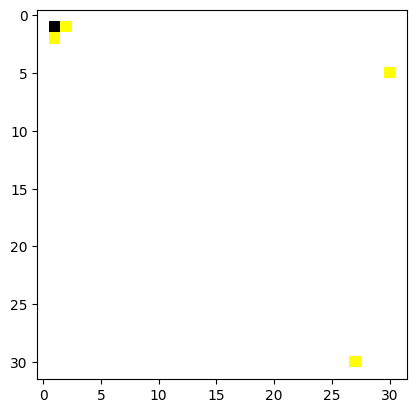

In [96]:
featureDL= DataLoader(torch.FloatTensor(feature))
targetDL=DataLoader(label, batch_size=1)
# 채널이 앞에 있네? -> conv2d 위해 shape 자동 변경해줌
# 이미지 시각화 -> shape 변경이 필요함 (행,열,채널)
for f in featureDL:
    plt.imshow(f.squeeze().permute(1,2,0))
    print(f.shape)
    break

In [69]:
class ImgMCF2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 특징 추출 
        self.cnn_layer=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10,
                                    kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.cnn_layer2=nn.Sequential(
            nn.Conv2d(10,30,3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        # 학습
        
        self.hd_layer=nn.Linear(30*6*6,50)
        self.out_layer=nn.Linear(50,10)

    # 순방향 학습 메서드
    def forward(self, input):
        self.cnn_layer(input)

        out=out.view(out.shape[0], -1)

        out=self.hd_layer(out)
        out=F.relu(out)

        out=self.out_layer(out)
        return out

In [76]:
feature.shape

(50000, 3, 32, 32)

In [75]:
feature=feature.to_numpy().reshape(-1,3,32,32)
trainDS=Custom_Dataset(feature, label)
testDS=Custom_Dataset(testF, targetF)

In [77]:
BATCH_SIZE=50
trainDL= DataLoader(trainDS, batch_size=BATCH_SIZE)
testDL=DataLoader(testDS, batch_size=BATCH_SIZE)

In [78]:
# 파라미터 선언
LR=0.001
model=ImgMCF2()
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)
criterion= nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=LR)
model.parameters

<bound method Module.parameters of ImgMCF2(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hd_layer): Linear(in_features=1080, out_features=50, bias=True)
  (out_layer): Linear(in_features=50, out_features=10, bias=True)
)>

In [79]:
for f, t in trainDL:
    print(f, t)

RuntimeError: stack expects each tensor to be equal size, but got [6] at entry 0 and [9] at entry 1

In [118]:
EPOCH=5
cnt=0
loss_list, iteration_list, accuaracy_list= [],[],[]
predictions_list, labels_list=[],[]

In [119]:
for ep in range(EPOCH):
    for images, labels in trainDL:

        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)

        outputs= model(train)
        loss= criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt+=1
        if ~(cnt%50):
            total, correct=0,0
            for images, labels in testDL:
                images, labels= images.to(DEVICE), labels.to(DEVICE)
                labels_list.append(labels)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs, 1)[1].to(DEVICE)
                predictions_list.append(predictions)
                correct+=(predictions==labels).sum()
                total+=len(labels)
            
            accuaracy=correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(cnt)
            accuaracy_list.append(accuaracy)
        if ~(cnt%500):
            print(f'Iteration: {cnt}, Loss: {loss.data}, Accuracy: {accuaracy}%')


IndexError: index 12288 is out of bounds for axis 0 with size 10000